In [ ]:
from google.colab import files
uploaded = files.upload()

Saving chinook.db to chinook.db


In [ ]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
query = """
SELECT
    i.invoice_id,
    DATE(i.invoice_date) AS invoice_date,
    i.customer_id,
    il.track_id,
    CASE
        WHEN g.name IN ('Rock', 'Alternative & Punk', 'Metal', 'Alternative', 'Heavy Metal') THEN 'rock'
        ELSE 'others'
    END AS genre_category,
    il.unit_price
FROM invoice i
JOIN invoice_line il ON i.invoice_id = il.invoice_id
JOIN track t ON il.track_id = t.track_id
JOIN genre g ON t.genre_id = g.genre_id
JOIN media_type mt ON t.media_type_id = mt.media_type_id
WHERE mt.name IN (
  'MPEG audio file',
  'AAC audio file',
  'Protected AAC audio file',
  'Purchased AAC audio file'
)
  AND strftime('%Y', i.invoice_date) = '2020';
"""


In [ ]:
conn = sqlite3.connect('/content/chinook.db')

In [ ]:
pd.read_sql_query("SELECT DISTINCT name FROM media_type;", conn)

,name
0,MPEG audio file
1,Protected AAC audio file
2,Protected MPEG-4 video file
3,Purchased AAC audio file
4,AAC audio file


In [ ]:
df = pd.read_sql_query(query, conn)

In [ ]:
df.head()

,invoice_id,invoice_date,customer_id,track_id,genre_category,unit_price
0,465,2020-01-12,21,149,rock,0.99
1,465,2020-01-12,21,150,rock,0.99
2,465,2020-01-12,21,151,rock,0.99
3,465,2020-01-12,21,152,rock,0.99
4,465,2020-01-12,21,153,rock,0.99


In [ ]:
# Проверка на пропуски
print(df.isnull().sum())

invoice_id        0
invoice_date      0
customer_id       0
track_id          0
genre_category    0
unit_price        0
dtype: int64


In [ ]:
# Проверка на дубликаты
print(df.duplicated().sum())

2


In [ ]:
# Смотрим дубликаты
df[df.duplicated(keep=False)]
# видим, что дубликаты идентичны, новой информации не несут, поэтому удалим их (вполне возможно,  что это ошибки при внесении данных)

,invoice_id,invoice_date,customer_id,track_id,genre_category,unit_price
377,517,2020-05-16,3,2573,others,0.99
382,517,2020-05-16,3,2573,others,0.99
989,593,2020-11-23,12,1042,others,0.99
997,593,2020-11-23,12,1042,others,0.99


In [ ]:
df = df.drop_duplicates()

In [ ]:
# Проверим еще раз дубликаты
print(df.duplicated().sum())

0


In [ ]:
# Приведение даты к первому дню месяца
df['invoice_date'] = pd.to_datetime(df['invoice_date']).dt.to_period('M').dt.to_timestamp()

In [ ]:
df.head(20)

,invoice_id,invoice_date,customer_id,track_id,genre_category,unit_price
0,465,2020-01-01,21,149,rock,0.99
1,465,2020-01-01,21,150,rock,0.99
2,465,2020-01-01,21,151,rock,0.99
3,465,2020-01-01,21,152,rock,0.99
4,465,2020-01-01,21,153,rock,0.99
5,465,2020-01-01,21,154,rock,0.99
6,465,2020-01-01,21,155,rock,0.99
7,466,2020-01-01,30,428,rock,0.99
8,466,2020-01-01,30,2379,rock,0.99
9,466,2020-01-01,30,73,others,0.99


ВИЗУАЛИЗАЦИЯ

1. Количество купленных треков

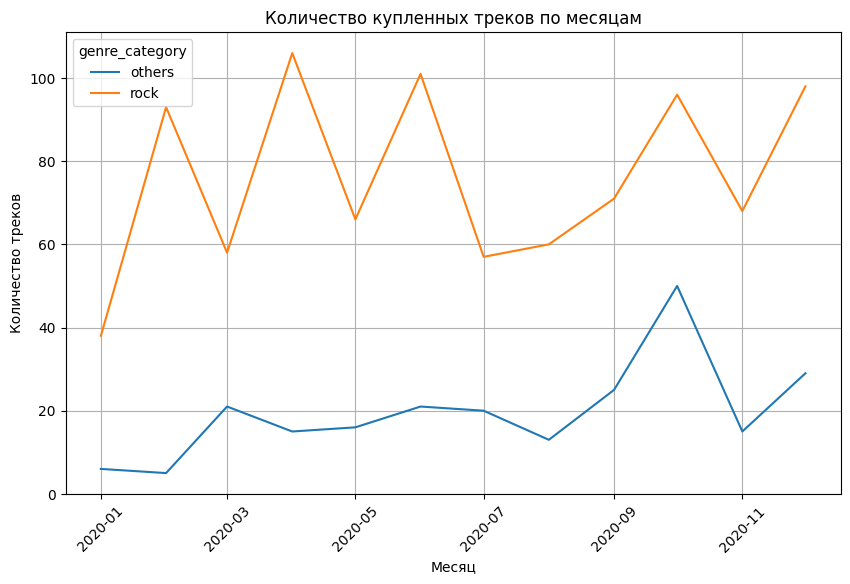

In [ ]:
tracks_monthly = df.groupby(['invoice_date', 'genre_category'])['track_id'].count().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(data=tracks_monthly, x='invoice_date', y='track_id', hue='genre_category')
plt.title('Количество купленных треков по месяцам')
plt.ylabel('Количество треков')
plt.xlabel('Месяц')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

2. Число чеков

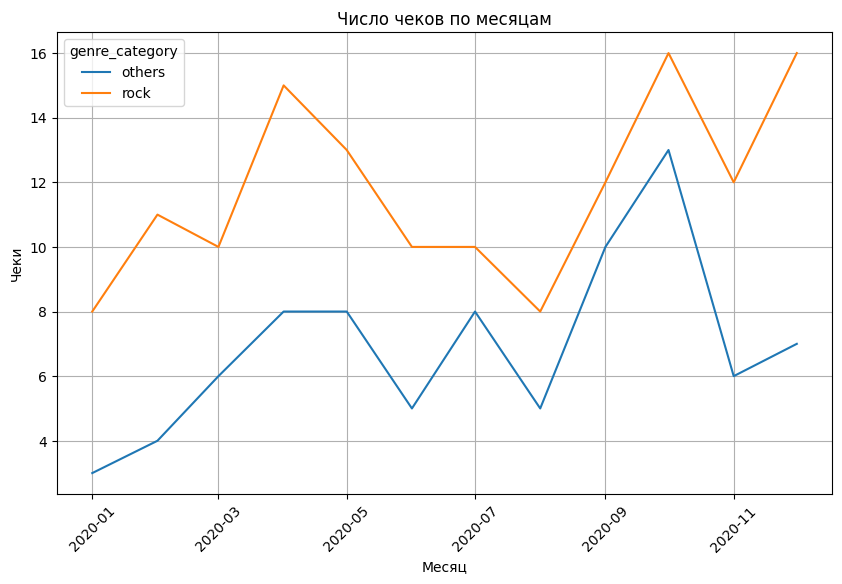

In [ ]:
invoices_monthly = df.groupby(['invoice_date', 'genre_category'])['invoice_id'].nunique().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(data=invoices_monthly, x='invoice_date', y='invoice_id', hue='genre_category')
plt.title('Число чеков по месяцам')
plt.ylabel('Чеки')
plt.xlabel('Месяц')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

3. Число покупателей


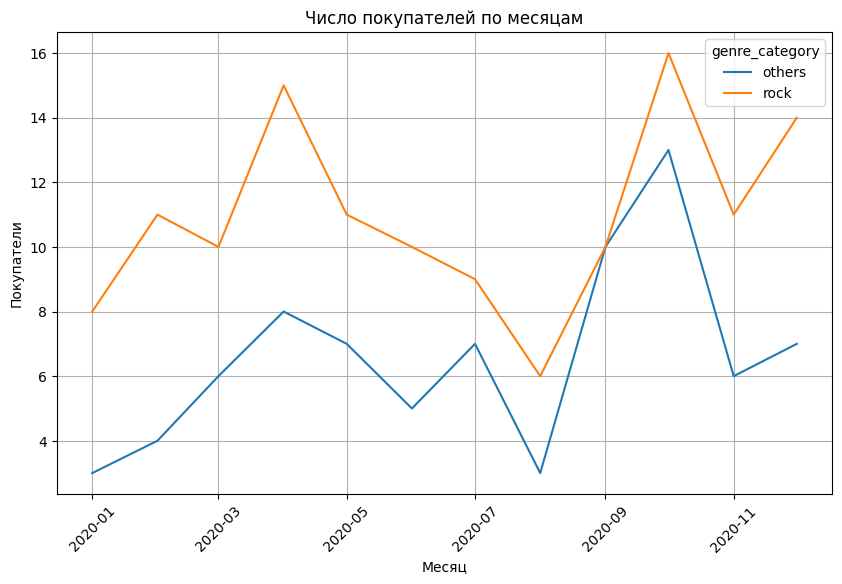

In [ ]:
customers_monthly = df.groupby(['invoice_date', 'genre_category'])['customer_id'].nunique().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(data=customers_monthly, x='invoice_date', y='customer_id', hue='genre_category')
plt.title('Число покупателей по месяцам')
plt.ylabel('Покупатели')
plt.xlabel('Месяц')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

4. Общая стоимость треков

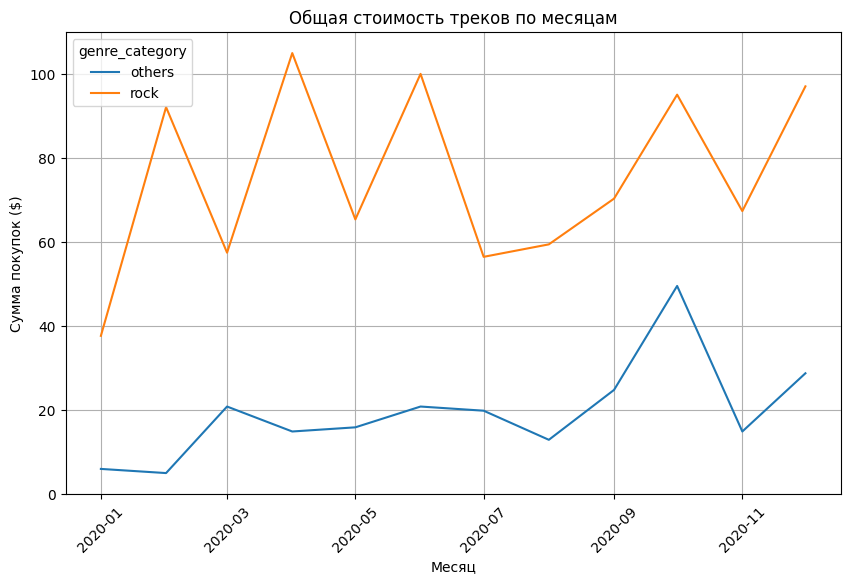

In [ ]:
revenue_monthly = df.groupby(['invoice_date', 'genre_category'])['unit_price'].sum().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(data=revenue_monthly, x='invoice_date', y='unit_price', hue='genre_category')
plt.title('Общая стоимость треков по месяцам')
plt.ylabel('Сумма покупок ($)')
plt.xlabel('Месяц')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Вывод:
- Жанры в категории 'rock' демонстрируют устойчивый спрос в течение года.
- В категории 'others' могут наблюдаться всплески в определённые месяцы (например, перед праздниками).
- Нет ярко выраженной сезонности, но можно отметить, что январь и декабрь обычно показывают рост по всем метрикам.